In [8]:
#Loading libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

In [9]:
# Loading datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [17]:
test.info()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 377 entries, ID to X385
dtypes: int64(369), object(8)
memory usage: 12.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 378 entries, ID to X385
dtypes: float64(1), int64(369), object(8)
memory usage: 12.1+ MB


In [23]:
test.head()
train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Separate features and target
X_train = train.drop(['ID', 'y'], axis=1)
y_train = train['y']
X_test = test.drop('ID', axis=1)

In [12]:
# Calculate variances only for numeric columns
variances = X_train.select_dtypes(include=np.number).var()

# Identify zero-variance columns
# We only consider columns that were included in the variance calculation
zero_var_cols = [col for col in variances.index if variances[col] == 0]

# Remove these columns from both train and test
X_train = X_train.drop(zero_var_cols, axis=1)
X_test = X_test.drop(zero_var_cols, axis=1)

In [13]:
# Check null values
print("Train nulls:\n", X_train.isnull().sum())
print("\nTest nulls:\n", X_test.isnull().sum())

# Check unique values
print("\nTrain unique value counts:")
for col in X_train.columns:
    print(f"{col}: {len(X_train[col].unique())}")

print("\nTest unique value counts:")
for col in X_test.columns:
    print(f"{col}: {len(X_test[col].unique())}")

Train nulls:
 X0      0
X1      0
X2      0
X3      0
X4      0
       ..
X380    0
X382    0
X383    0
X384    0
X385    0
Length: 364, dtype: int64

Test nulls:
 X0      0
X1      0
X2      0
X3      0
X4      0
       ..
X380    0
X382    0
X383    0
X384    0
X385    0
Length: 364, dtype: int64

Train unique value counts:
X0: 47
X1: 27
X2: 44
X3: 7
X4: 4
X5: 29
X6: 12
X8: 25
X10: 2
X12: 2
X13: 2
X14: 2
X15: 2
X16: 2
X17: 2
X18: 2
X19: 2
X20: 2
X21: 2
X22: 2
X23: 2
X24: 2
X26: 2
X27: 2
X28: 2
X29: 2
X30: 2
X31: 2
X32: 2
X33: 2
X34: 2
X35: 2
X36: 2
X37: 2
X38: 2
X39: 2
X40: 2
X41: 2
X42: 2
X43: 2
X44: 2
X45: 2
X46: 2
X47: 2
X48: 2
X49: 2
X50: 2
X51: 2
X52: 2
X53: 2
X54: 2
X55: 2
X56: 2
X57: 2
X58: 2
X59: 2
X60: 2
X61: 2
X62: 2
X63: 2
X64: 2
X65: 2
X66: 2
X67: 2
X68: 2
X69: 2
X70: 2
X71: 2
X73: 2
X74: 2
X75: 2
X76: 2
X77: 2
X78: 2
X79: 2
X80: 2
X81: 2
X82: 2
X83: 2
X84: 2
X85: 2
X86: 2
X87: 2
X88: 2
X89: 2
X90: 2
X91: 2
X92: 2
X94: 2
X95: 2
X96: 2
X97: 2
X98: 2
X99: 2
X100: 2
X101: 2


In [20]:
# Select only numerical columns before scaling
X_train_numeric = X_train.select_dtypes(include=np.number)
X_test_numeric = X_test.select_dtypes(include=np.number)

X_train_scaled = scaler.fit_transform(X_train_numeric)
X_test_scaled = scaler.transform(X_test_numeric)

# Determine optimal number of components (retain 95% variance)
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Original features: {X_train.shape[1]}")
print(f"Reduced features: {X_train_pca.shape[1]}")

Original features: 364
Reduced features: 144


In [21]:
# Initialize XGBoost regressor
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=42
)

# Cross-validation
scores = cross_val_score(xgb, X_train_pca, y_train, cv=5, scoring='r2')
print(f"Cross-validation R2 scores: {scores}")
print(f"Mean R2: {np.mean(scores)}")

# Train final model
xgb.fit(X_train_pca, y_train)

# Predict on test set
y_pred = xgb.predict(X_test_pca)

Cross-validation R2 scores: [0.48755818 0.39076749 0.51224298 0.45928055 0.51364488]
Mean R2: 0.47269881509272366


In [22]:
# Create submission file
submission = pd.DataFrame({'ID': test['ID'], 'y': y_pred})
submission.to_csv('submission.csv', index=False)

<Figure size 1000x2000 with 0 Axes>

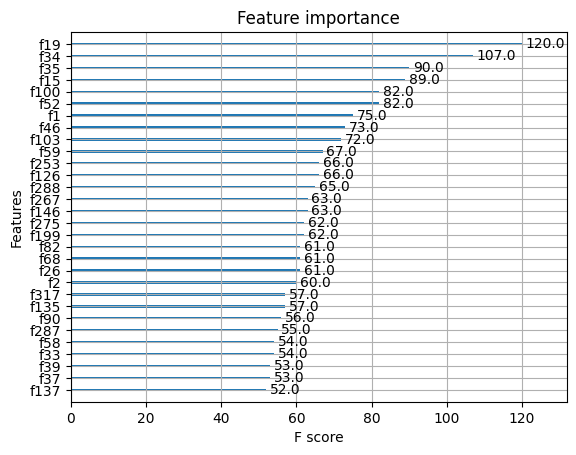

In [24]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Retrain on original features to get importance
xgb.fit(X_train_scaled, y_train)
plt.figure(figsize=(10, 20))
plot_importance(xgb, max_num_features=30)
plt.show()